## GAN(Generative Adversarial Network)

GAN, 생성적 적대 신경망라는 이름에도 들어나 있듯이, 데이터를 생성하는 모델이다. 또한 적대라는 의미는 모델의 구조를 보면 쉽게 파악할 수 있다. GAN은 크게 데이터를 만들어 내는 Generator와 Generator가 만들어내는 이미지와 실제이미지 중 진짜를 판별하는 Discriminator로 이루어져 있다. GAN의 목적은 Generator와 Discriminator가 서로 경쟁을 하면서, 최종적으로 Generator가 만들어 내는 데이터의 분포와 학습에 사용하는 실제 데이터의 분포를 같아지도록 만드는 것이다. 이러한 목적을 달성하기 위해서는 loss function을 잘 설정해야 한다. GAN의 loss function은 log-likehood를 사용하든, MSELoss를 사용하든 한가지만 알면된다. 첫번째로, Discriminator가 학습할때는, Disciminator가 실제이미지가 진짜(1)로 판별하고, Generator가 만들어내는 이미지를 가짜(0)로 판별하도록 학습해야한다. 두번째로, Generator에서 학습할때는,  Discrimator가 Genrator가 만들어내는 이미지가 진짜(1)로 판별하도록 학습해야한다. 이러한 경쟁적 학습 알고리즘을 거치면서 서로 발전하면서 최종적으로, Generator의 성능을 향상 시킬 수 있는 것이다.   

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
batch_size = 256
learning_rate = 0.001
epoch = 10

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

c:\users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader= DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [5]:
for index, [image, label] in enumerate(train_loader):
    x = image
    y = label
    print(x.shape)
    break

torch.Size([256, 1, 28, 28])


In [6]:
z_size = 50
middle_size = 200

In [7]:
#기본적인 GAN 
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(z_size, middle_size),
                                    nn.BatchNorm1d(middle_size),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(middle_size, 28*28),
                                    nn.BatchNorm1d(28*28),
                                    nn.Tanh())
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = out.view(batch_size, 1, 28, 28)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(28*28, middle_size),
                                    nn.BatchNorm1d(middle_size),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(middle_size, 1),
                                    nn.BatchNorm1d(1),
                                    nn.Sigmoid())
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
    
    def forward(self, x):
        out = x.view(batch_size, -1)
        out = self.layer1(out)
        out = self.layer2(out)
        return out
        

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

cuda


In [9]:
loss_func = nn.MSELoss()
gen_optim = optim.Adam(generator.parameters(), lr=learning_rate)
dis_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)

ones_label = torch.ones(batch_size, 1).to(device)
zeros_label = torch.zeros(batch_size, 1).to(device)

In [10]:
best_gen_loss = float('inf') #초기 loss는 무한대로 설정

for i in range(epoch):
    for j, (image, label) in enumerate(train_loader):
        #Discrimator 학습
        dis_optim.zero_grad()
        
        image = image.to(device)
        z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1).to(device)
        gen_fake = generator(z) #(batch_size, 1, 28, 28)
        dis_fake = discriminator(gen_fake)
        
        dis_real = discriminator(image)
        dis_loss = loss_func(dis_fake, zeros_label)+ loss_func(dis_real, ones_label)
        dis_loss.backward()
        dis_optim.step()
        
        #Generator 학습
        gen_optim.zero_grad()
        z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1).to(device)
        gen_fake = generator(z) #(batch_size, 1, 28, 28)
        dis_fake = discriminator(gen_fake)  
        
        gen_loss = loss_func(dis_fake, ones_label)
        gen_loss.backward()
        gen_optim.step()
        
       
    print("{}th iteration gen_loss: {} dis_loss: {}".format(i+1,gen_loss.data,dis_loss.data))
    
    if gen_loss < best_gen_loss:
        best_gen_loss = gen_loss
        print(f'best_gen_loss update')
        torch.save([generator,discriminator],'./GAN_Model/basic_gan.pkl')
    

1th iteration gen_loss: 0.2796860337257385 dis_loss: 0.4944559335708618
best_gen_loss update
2th iteration gen_loss: 0.2940012812614441 dis_loss: 0.47192350029945374
3th iteration gen_loss: 0.30829310417175293 dis_loss: 0.4451826214790344
4th iteration gen_loss: 0.33777546882629395 dis_loss: 0.4360648989677429
5th iteration gen_loss: 0.3459550142288208 dis_loss: 0.4138697385787964
6th iteration gen_loss: 0.3564240038394928 dis_loss: 0.3863994777202606
7th iteration gen_loss: 0.38878756761550903 dis_loss: 0.3801610469818115
8th iteration gen_loss: 0.4159921407699585 dis_loss: 0.36554670333862305
9th iteration gen_loss: 0.36321377754211426 dis_loss: 0.3467530608177185
10th iteration gen_loss: 0.44370558857917786 dis_loss: 0.3397599756717682


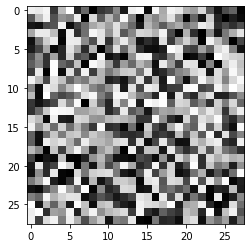

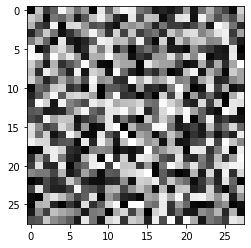

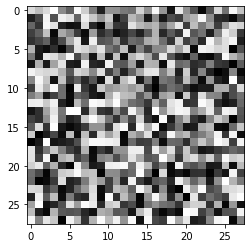

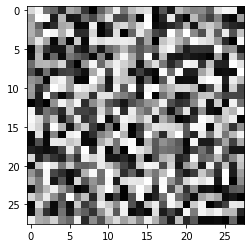

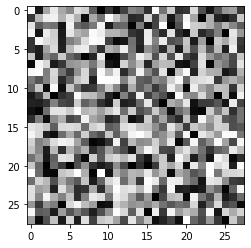

In [11]:
import matplotlib.pyplot as plt

generator, discriminator = torch.load('./GAN_Model/basic_gan.pkl')
generator = generator.to(device)
test_z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1).to(device)
gen_fake = generator(test_z)

for i in range(5):
    img = torch.squeeze(gen_fake[i]).cpu().detach().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()
    

## DCGAN

한마디로 Covolutional 연산을 GAN에 이용한 것. Generator는 전치 합성곱 연산을 통해 이미지를 생성한다. 논문에서는 어떻게 하면 학습이 잘되는지 몇 가지를 추천해줌.

1. 풀링연산을 합성곱 연산으로 대체하고, Generator 네트워크는 전치 합성곱 연산을 사용한다.
2. Generator와 Discriminator에 배치 정규화를 사용한다.
3. Fully connected layer는 사용하지 않는다.
4. Generator network에는 마지막에 사용하는 Tanh 제외하고 모든 활성화함수에 ReLU를 사용한다.
5. Discriminator의 모든 활성화 함수로는 Leaky ReLU를 사용한다.

In [12]:
#DCGAN 
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.reshape = nn.Sequential(nn.Linear(z_size, 7*7*256),
                                     nn.BatchNorm1d(7*7*256),
                                     nn.ReLU())
        self.conv1 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU()) #128*14*14
        self.conv2 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU()) #64*14*14
        self.conv3 = nn.Sequential(nn.ConvTranspose2d(64, 16, 4, 2, 1),
                                   nn.ReLU()) #16*28*28
        self.conv4 = nn.Sequential(nn.Conv2d(16, 1, 3, 1, 1),
                                   nn.BatchNorm2d(1),
                                   nn.Tanh()) #1*28*28
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, z):
        out = self.reshape(z)
        out = out.view(batch_size, 256, 7, 7)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        return out #batch*1*28*28

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, 1, 1),
                                   nn.BatchNorm2d(8),
                                   nn.LeakyReLU()) #8*28*28
        self.conv2 = nn.Sequential(nn.Conv2d(8, 16, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.LeakyReLU()) #16*14*14
        self.conv3 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1),
                                   nn.BatchNorm2d(32),
                                   nn.LeakyReLU()) #32*14*14
        self.conv4 = nn.Sequential(nn.Conv2d(32, 64, 3, 2, 1),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU()) #64*7*7
        self.fc = nn.Sequential(nn.Linear(64*7*7, 1),
                                nn.Sigmoid())
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)
        
        return out #batch_size*1
        

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [14]:
loss_func = nn.MSELoss()
gen_optim = optim.Adam(generator.parameters(), lr=learning_rate)
dis_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)

ones_label = torch.ones(batch_size, 1).to(device)
zeros_label = torch.zeros(batch_size, 1).to(device)

In [15]:
best_gen_loss = float('inf') #초기 loss는 무한대로 설정

for i in range(epoch):
    for j, (image, label) in enumerate(train_loader):
        #Discrimator 학습
        dis_optim.zero_grad()
        image = image.to(device)
        z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1).to(device)
        gen_fake = generator(z) #(batch_size, 1, 28, 28)
        dis_fake = discriminator(gen_fake)
        
        dis_real = discriminator(image)
        dis_loss = loss_func(dis_fake, zeros_label)+ loss_func(dis_real, ones_label)
        dis_loss.backward()
        dis_optim.step()
        
        #Generator 학습
        gen_optim.zero_grad()
        z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1).to(device)
        gen_fake = generator(z) #(batch_size, 1, 28, 28)
        dis_fake = discriminator(gen_fake)  
        
        gen_loss = loss_func(dis_fake, ones_label)
        gen_loss.backward()
        gen_optim.step()
        
       
    print("{}th iteration gen_loss: {} dis_loss: {}".format(i+1,gen_loss.data,dis_loss.data))
    
    if gen_loss < best_gen_loss:
        best_gen_loss = gen_loss
        print(f'best_gen_loss update')
        torch.save([generator,discriminator],'./GAN_Model/DCGAN.pkl')
    

1th iteration gen_loss: 0.9999996423721313 dis_loss: 7.089682185323909e-05
best_gen_loss update
2th iteration gen_loss: 0.9999991655349731 dis_loss: 2.3844906536396593e-05
best_gen_loss update
3th iteration gen_loss: 0.9999987483024597 dis_loss: 3.8616258279944304e-06
best_gen_loss update
4th iteration gen_loss: 0.9999978542327881 dis_loss: 2.5393369469384197e-06
best_gen_loss update
5th iteration gen_loss: 0.9999948143959045 dis_loss: 2.1731746073783142e-06
best_gen_loss update
6th iteration gen_loss: 0.9767929911613464 dis_loss: 0.008780248463153839
best_gen_loss update
7th iteration gen_loss: 0.9996135234832764 dis_loss: 1.4919504792487714e-05
8th iteration gen_loss: 0.999995231628418 dis_loss: 3.1675178888690425e-06
9th iteration gen_loss: 0.9999905228614807 dis_loss: 1.990710103427773e-07
10th iteration gen_loss: 0.9999877214431763 dis_loss: 1.0282000175720896e-06


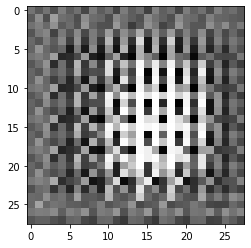

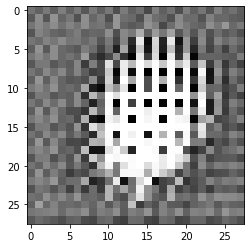

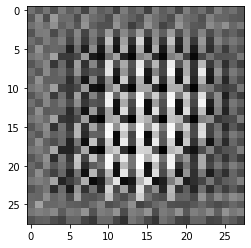

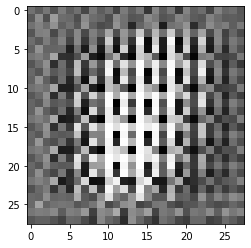

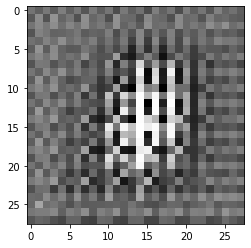

In [16]:
import matplotlib.pyplot as plt

generator, discriminator = torch.load('./GAN_Model/DCGAN.pkl')
generator = generator.to(device)
test_z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1).to(device)
gen_fake = generator(test_z)

for i in range(5):
    img = torch.squeeze(gen_fake[i]).cpu().detach().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()